<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=9b155340561844787eaf29d16ef51771d6d2799d4dc65e52ef6a7956a25c281c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ttkfvvq2/wheels/55/59/29/0fb1c635652157734

In [ ]:
from dul_2021.utils.hw7_utils import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


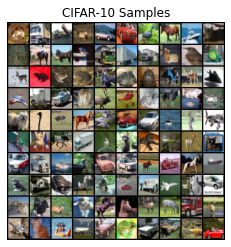

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Upsample and Downsample convolutions

In [ ]:
!pip install einops

In [ ]:
import einops
import torch
import torch.nn as nn

class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = einops.rearrange(x, 'b (u v c) h w -> b c (u h) (w v)', u=2, v=2) # Depth2Space
        x = self.conv(x)
        return x


class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = einops.rearrange(x, 'b c (h u) (w v) -> b (u v) c h w', u=2, v=2)
        x = torch.mean(x, dim=1)
        x = self.conv(x)
        return x

## Resnet blocks

In [ ]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.seq = nn.Sequential(nn.BatchNorm2d(in_dim),
                                 nn.ReLU(),
                                 nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                 nn.BatchNorm2d(n_filters),
                                 nn.ReLU(),
                                 Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
                                 
        self.upsample = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.seq(x) + self.upsample(x)


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.seq = nn.Sequential(nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                 nn.ReLU(),
                                 Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.downsample = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.seq(x) + self.downsample(x)

class ResBlock(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size=(3, 3)):
        super().__init__()
        self.seq = nn.Sequential(nn.ReLU(),
                                 nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
    def forward(self, x):
        return self.seq(x) + x

In [ ]:
a = torch.tensor(0, device=device, dtype=torch.int)
a % 10

tensor(0, device='cuda:0', dtype=torch.int32)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_filters=128, latent_dim=128):
        super().__init__()
        self.normal = torch.distributions.normal.Normal(0, 1)
        self.lat_dim = latent_dim
        self.counter = torch.tensor(0, dtype=torch.int)
        self.linear = nn.Linear(latent_dim, 4 * 4 * 256)
        
        self.generator = nn.Sequential(ResnetBlockUp(in_dim=256, n_filters=n_filters),
                                       ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                       ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                       nn.BatchNorm2d(n_filters),
                                       nn.ReLU(),
                                       nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
                                       nn.Tanh())
       
    def sample_normal(self, upper_bound=4000):
        self.normal_z = self.normal.sample((upper_bound, self.lat_dim)).to(device)

    def forward(self, n_samples=1024):
        if self.counter == 0:
            self.sample_normal()
        self.counter = (self.counter + 1) % 10

        z = self.normal_z[self.counter * n_samples : (self.counter + 1) * n_samples]
        x = self.linear(z)
        x = x.reshape(-1, 256, 4, 4)
        x = self.generator(x)
        return (x + 1) / 2

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_filters=128, latent_dim=128):
        super().__init__()
        
        self.res_seq = nn.Sequential(ResnetBlockDown(3, n_filters),
                                     ResnetBlockDown(n_filters, n_filters),
                                     ResBlock(n_filters, n_filters),
                                     ResBlock(n_filters, n_filters))

        self.to_prob = nn.Sequential(nn.Linear(128, 1),
                                     nn.Sigmoid())

    def forward(self, image):
        x = self.res_seq(image)
        x = x.mean([2, 3])
        x = self.to_prob(x)
        return x

## Load CIFAR data

In [ ]:
batch_size = 256
n_critic = 5
num_epochs = 40
λ = 10

In [ ]:
train_data = load_q1_data()

Files already downloaded and verified


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True)

## Define objects

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

G = Generator().to(device)
gen_opt = Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.9))
g_sched = StepLR(gen_opt, step_size=100, gamma=0.95)

D = Discriminator().to(device)
dis_opt = Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.9))
d_sched = StepLR(dis_opt, step_size=100, gamma=0.95)

## Training loop

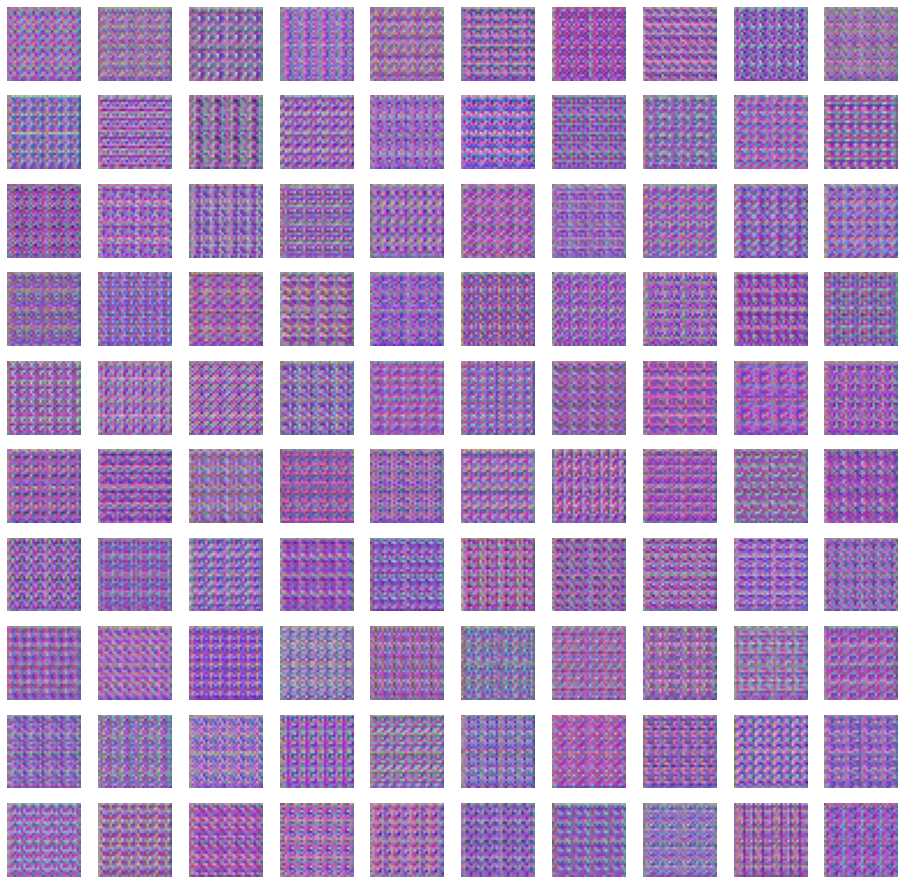

EPOCH 0
Batch #0
	 D-loss: 9.958127975463867
Batch #1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


	 D-loss: 9.872891426086426
Batch #2
	 D-loss: 9.789552688598633
Batch #3
	 D-loss: 9.674216270446777
Batch #4
	 D-loss: 9.481935501098633
	 G-loss: -0.34345611929893494
Batch #5
	 D-loss: 9.322834014892578
Batch #6
	 D-loss: 8.733901977539062
Batch #7
	 D-loss: 7.999484062194824
Batch #8
	 D-loss: 7.0298662185668945
Batch #9
	 D-loss: 9.630681991577148
	 G-loss: -0.8653963804244995
Batch #10
	 D-loss: 9.73151683807373
Batch #11
	 D-loss: 8.825584411621094
Batch #12
	 D-loss: 7.759181499481201
Batch #13
	 D-loss: 7.746318340301514
Batch #14
	 D-loss: 7.7913408279418945
	 G-loss: -0.37293437123298645
Batch #15
	 D-loss: 8.088753700256348
Batch #16
	 D-loss: 7.863447189331055
Batch #17
	 D-loss: 7.791088104248047
Batch #18
	 D-loss: 7.792260646820068
Batch #19
	 D-loss: 7.817838668823242
	 G-loss: -0.46828821301460266
Batch #20
	 D-loss: 8.228058815002441
Batch #21
	 D-loss: 8.350549697875977
Batch #22
	 D-loss: 8.4472074508667
Batch #23
	 D-loss: 8.437774658203125
Batch #24
	 D-loss: 8.

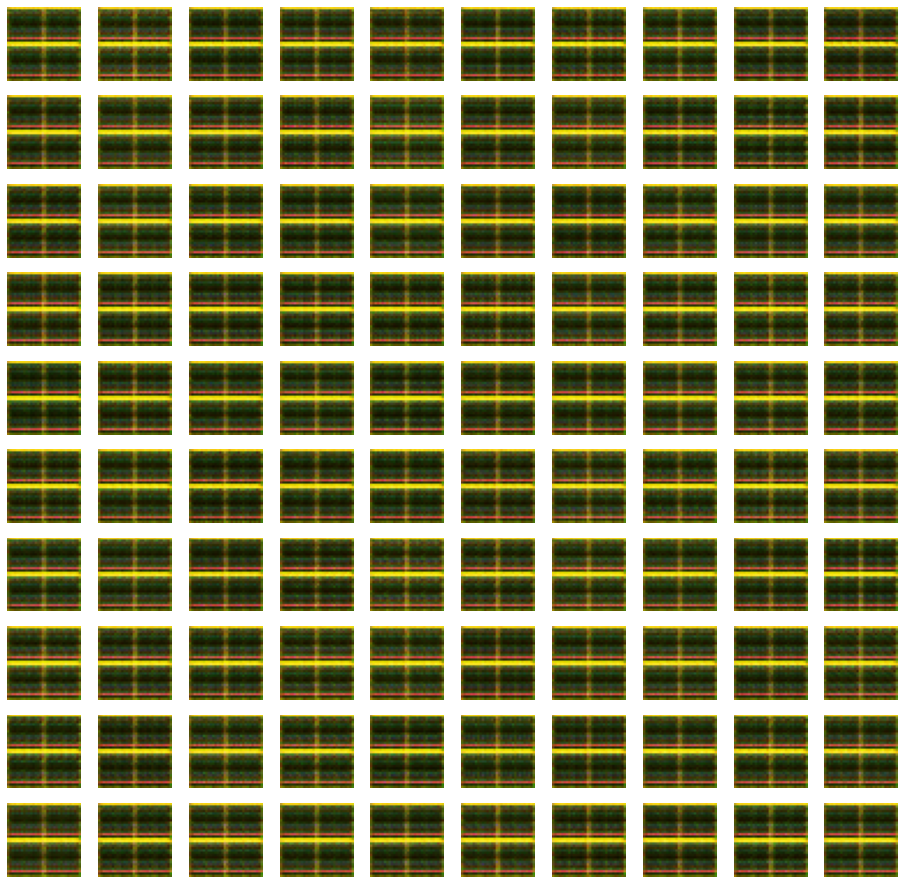

EPOCH 1
Batch #0
	 D-loss: 7.522033214569092
Batch #1
	 D-loss: 7.4516096115112305
Batch #2
	 D-loss: 7.284431457519531
Batch #3
	 D-loss: 7.212029457092285
Batch #4
	 D-loss: 7.148381233215332
	 G-loss: -0.3182604908943176
Batch #5
	 D-loss: 7.965512275695801
Batch #6
	 D-loss: 7.545103073120117
Batch #7
	 D-loss: 7.467909812927246
Batch #8
	 D-loss: 7.416768550872803
Batch #9
	 D-loss: 7.285540580749512
	 G-loss: -0.49243244528770447
Batch #10
	 D-loss: 7.773193359375
Batch #11
	 D-loss: 7.631194591522217
Batch #12
	 D-loss: 7.404383659362793
Batch #13
	 D-loss: 7.317586898803711
Batch #14
	 D-loss: 7.200837135314941
	 G-loss: -0.5652332305908203
Batch #15
	 D-loss: 7.5105133056640625
Batch #16
	 D-loss: 7.374372482299805
Batch #17
	 D-loss: 7.154766082763672
Batch #18
	 D-loss: 6.992875099182129
Batch #19
	 D-loss: 6.945745468139648
	 G-loss: -0.6696591377258301
Batch #20
	 D-loss: 7.382822036743164
Batch #21
	 D-loss: 6.994163513183594
Batch #22
	 D-loss: 6.991349697113037
Batch #2

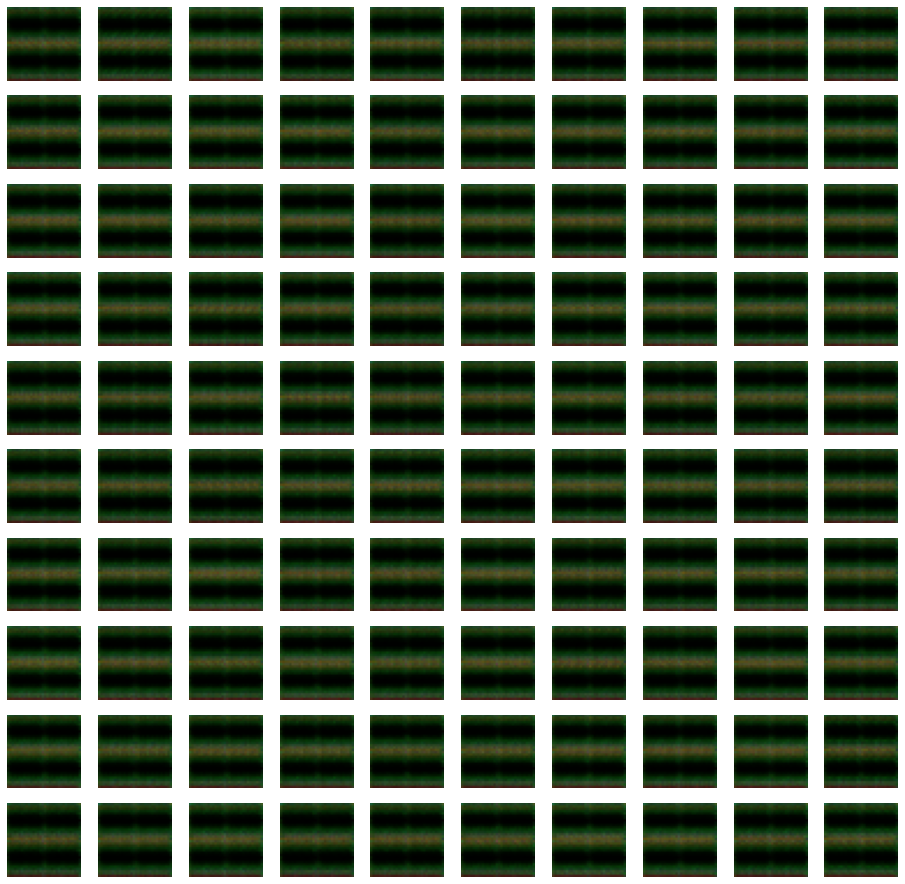

EPOCH 2
Batch #0
	 D-loss: 5.310312271118164
Batch #1
	 D-loss: 5.081536769866943
Batch #2
	 D-loss: 5.311553001403809
Batch #3
	 D-loss: 4.931022644042969
Batch #4
	 D-loss: 5.011165142059326
	 G-loss: -0.98358154296875
Batch #5
	 D-loss: 4.756669044494629
Batch #6
	 D-loss: 5.084268569946289
Batch #7
	 D-loss: 4.878684043884277
Batch #8
	 D-loss: 5.140167713165283
Batch #9
	 D-loss: 5.0405731201171875
	 G-loss: -0.9841176867485046
Batch #10
	 D-loss: 5.054774284362793
Batch #11
	 D-loss: 5.735141277313232
Batch #12
	 D-loss: 4.8917236328125
Batch #13
	 D-loss: 4.76391077041626
Batch #14
	 D-loss: 4.873003959655762
	 G-loss: -0.9845544099807739
Batch #15
	 D-loss: 4.948989391326904
Batch #16
	 D-loss: 5.417991638183594
Batch #17
	 D-loss: 5.081416130065918
Batch #18
	 D-loss: 4.56671667098999
Batch #19
	 D-loss: 4.618574142456055
	 G-loss: -0.990608811378479
Batch #20
	 D-loss: 4.68443489074707
Batch #21
	 D-loss: 4.79164981842041
Batch #22
	 D-loss: 4.892780303955078
Batch #23
	 D-lo

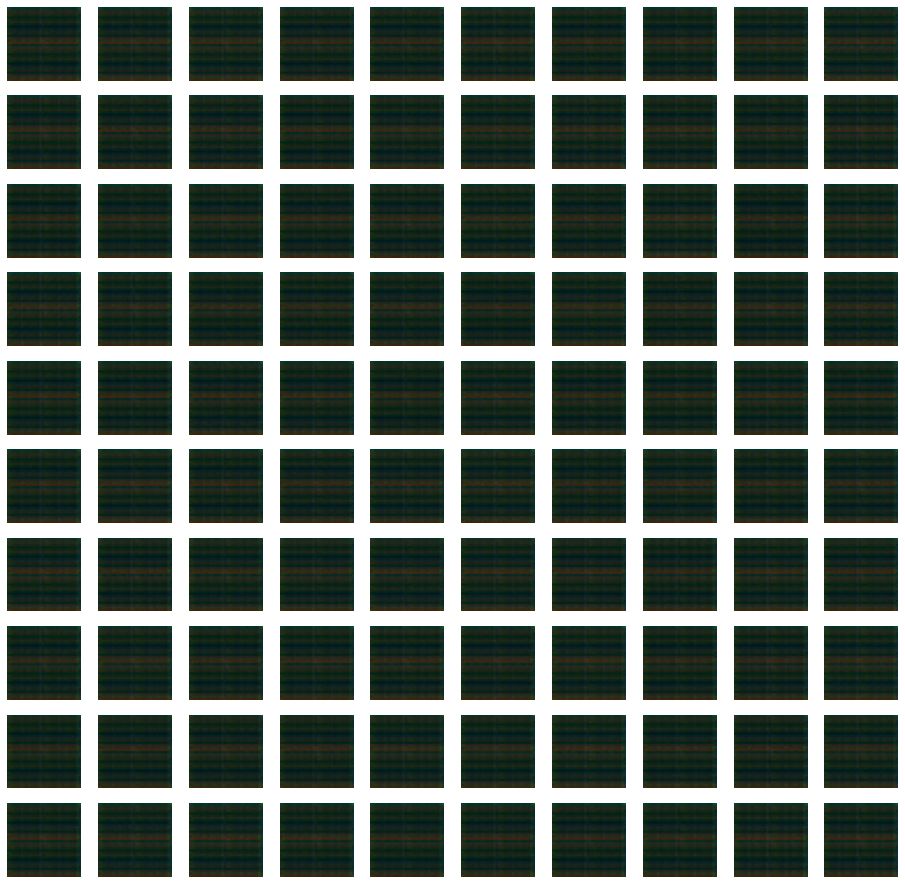

EPOCH 3
Batch #0
	 D-loss: 2.652726888656616
Batch #1
	 D-loss: 3.053515911102295
Batch #2
	 D-loss: 2.9714179039001465
Batch #3
	 D-loss: 2.7833728790283203
Batch #4
	 D-loss: 3.2538232803344727
	 G-loss: -0.4219930171966553
Batch #5
	 D-loss: 3.019470453262329
Batch #6
	 D-loss: 2.8166418075561523
Batch #7
	 D-loss: 2.7354626655578613
Batch #8
	 D-loss: 2.622772455215454
Batch #9
	 D-loss: 2.844481945037842
	 G-loss: -0.4066962003707886
Batch #10
	 D-loss: 3.368213653564453
Batch #11
	 D-loss: 5.798498153686523
Batch #12
	 D-loss: 2.9882261753082275
Batch #13
	 D-loss: 3.3730883598327637
Batch #14
	 D-loss: 3.8390932083129883
	 G-loss: -0.4055248498916626
Batch #15
	 D-loss: 3.215376377105713
Batch #16
	 D-loss: 3.5368943214416504
Batch #17
	 D-loss: 3.4536190032958984
Batch #18
	 D-loss: 3.6169748306274414
Batch #19
	 D-loss: 3.3271484375
	 G-loss: -0.3809698224067688
Batch #20
	 D-loss: 3.214329242706299
Batch #21
	 D-loss: 4.297021865844727
Batch #22
	 D-loss: 3.8518173694610596
B

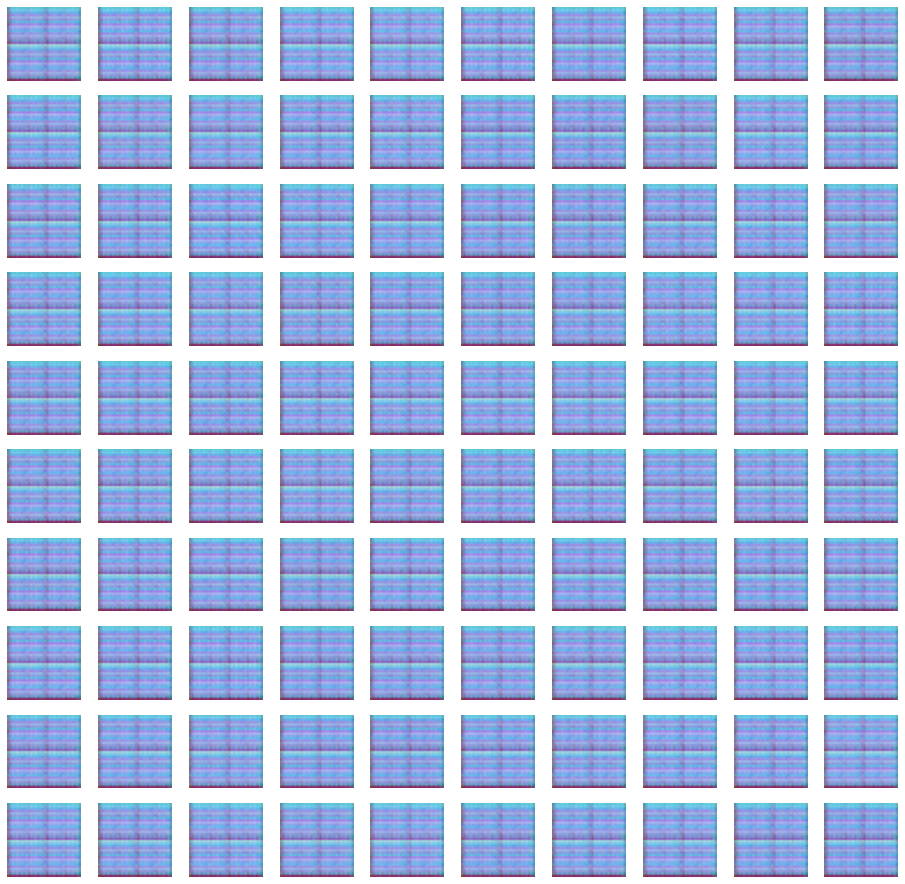

EPOCH 4
Batch #0
	 D-loss: 9.997016906738281
Batch #1
	 D-loss: 9.996956825256348
Batch #2
	 D-loss: 9.996792793273926
Batch #3
	 D-loss: 9.99682331085205
Batch #4
	 D-loss: 9.996294975280762
	 G-loss: -9.073053661268204e-05
Batch #5
	 D-loss: 9.99685287475586
Batch #6
	 D-loss: 9.996601104736328
Batch #7
	 D-loss: 9.99631404876709
Batch #8
	 D-loss: 9.995716094970703
Batch #9
	 D-loss: 9.995052337646484
	 G-loss: -0.00013485224917531013
Batch #10
	 D-loss: 9.994840621948242
Batch #11
	 D-loss: 9.993368148803711
Batch #12
	 D-loss: 9.990968704223633
Batch #13
	 D-loss: 9.987988471984863
Batch #14
	 D-loss: 9.981298446655273
	 G-loss: -0.0009484496549703181
Batch #15
	 D-loss: 9.964622497558594
Batch #16
	 D-loss: 9.880781173706055
Batch #17
	 D-loss: 8.209845542907715
Batch #18
	 D-loss: 9.161813735961914
Batch #19
	 D-loss: 9.512121200561523
	 G-loss: -1.0
Batch #20
	 D-loss: 9.77542495727539
Batch #21
	 D-loss: 9.40194034576416
Batch #22
	 D-loss: 9.791046142578125
Batch #23
	 D-loss

KeyboardInterrupt: ignored

In [ ]:
import numpy.random
from torch.distributions.uniform import Uniform

U = Uniform(0, 1)
grad_outputs = torch.ones((batch_size, 1), 
                          device=device, 
                          requires_grad=False)

for epoch in range(num_epochs):
    show_image(G)
    print(f"EPOCH {epoch}")
    for t, batch in enumerate(train_dataloader):
        print(f"Batch #{t}")
        
        size = batch[0].shape[0]
        x = batch[0].to(device)
        eps = U.sample((size, )).to(device)

        with torch.no_grad():
            x_gen = G(size)

        x_lin_sum  = torch.einsum('b, bchw -> bchw', eps, x)
        x_lin_sum += torch.einsum('b, bchw -> bchw', (1 - eps), x_gen)
        x_lin_sum.requires_grad = True

        gradient = torch.autograd.grad(D(x_lin_sum), x_lin_sum,
                                       grad_outputs=grad_outputs[:size],
                                       create_graph=True,
                                       retain_graph=True)[0]
    
        flat_grad = gradient.flatten(1, -1)
        grad_norm = torch.norm(flat_grad, dim=1, p=2)
        square_sum = (grad_norm - 1) ** 2

        d_loss = D(x_gen) - D(x) + λ * square_sum
        d_loss = d_loss.mean()
        print(f"\t D-loss: {d_loss.item()}")

        dis_opt.zero_grad()
        d_loss.backward()
        dis_opt.step() 

        if (t + 1) % n_critic == 0:
            g_loss = - D(G(batch_size))
            g_loss = g_loss.mean()
            print(f"\t G-loss: {g_loss.item()}")
            gen_opt.zero_grad()
            g_loss.backward()
            gen_opt.step()

        g_sched.step()
        d_sched.step()


In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [16., 16.]

In [ ]:
def get_image(generator):
    with torch.no_grad():
        im = generator(100)
    im = torch.permute(im, (0, 2, 3, 1))
    im = im.cpu().numpy() * 255
    im = im.astype(np.uint8)
    return im

def show_image(generator):
    images = get_image(generator)
    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            plt.subplot(10, 10, index + 1)
            plt.imshow(images[index])
            plt.axis('off')
    plt.show()

In [ ]:
G.counter

tensor(1, dtype=torch.int32)

In [ ]:
result = G(10)

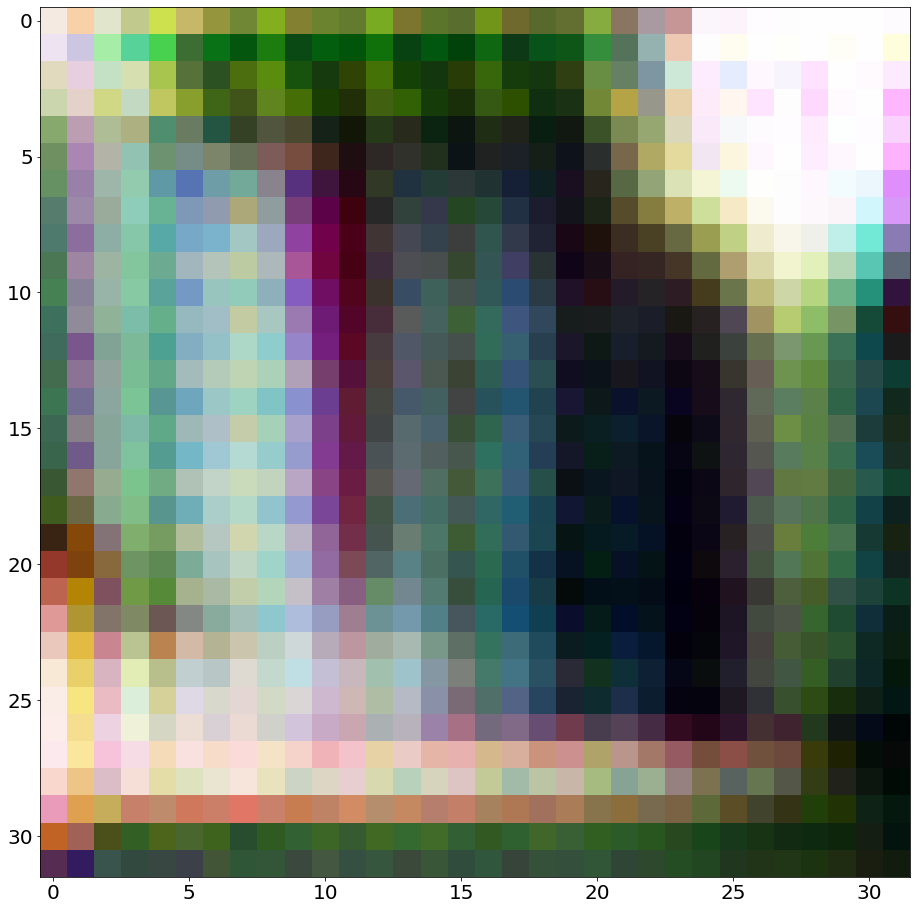

In [ ]:
my_image = torch.permute(result[8:9], (0, 2, 3, 1)).cpu().detach().numpy()
my_image *= 255
my_image = np.uint8(my_image)
plt.imshow(my_image[0])
plt.show()

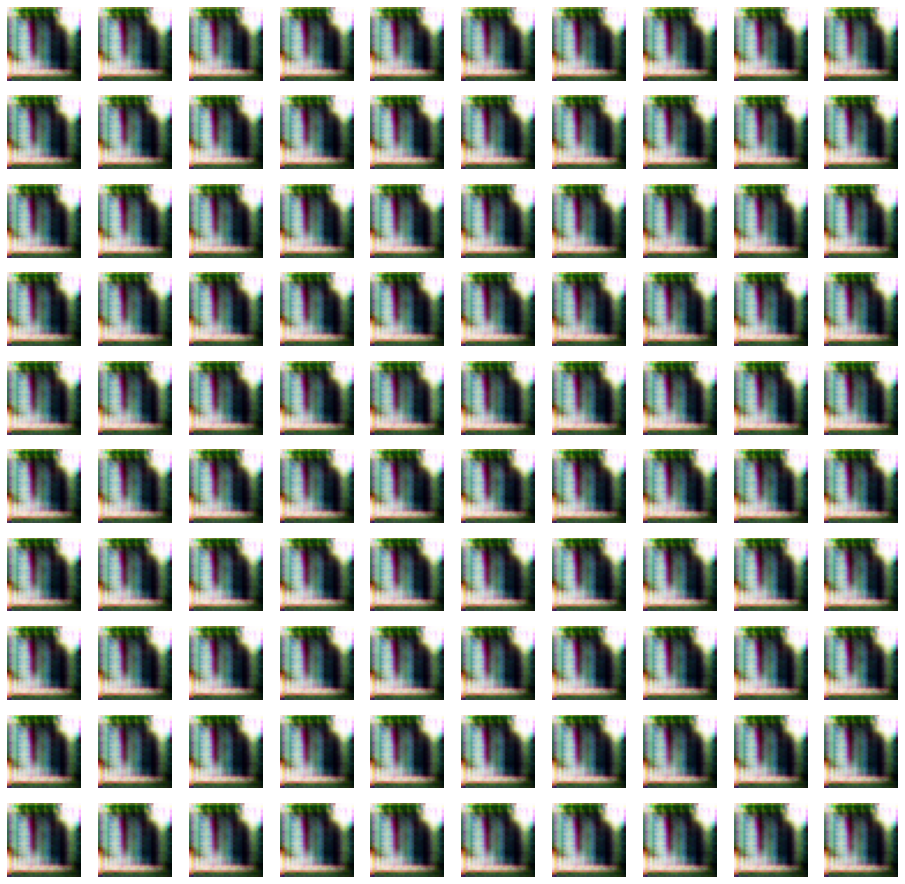

In [ ]:
show_image(G)

## Solution

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """

## Results

Files already downloaded and verified



..........Inception score: 6.062043


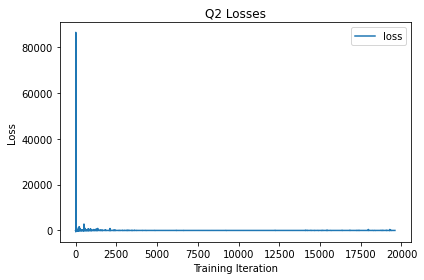

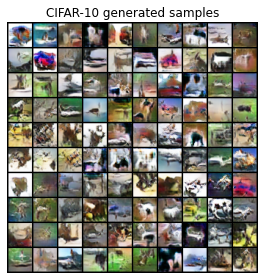

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


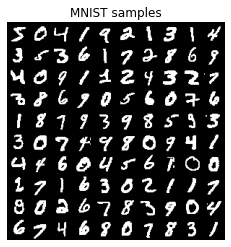

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """

## Results

In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

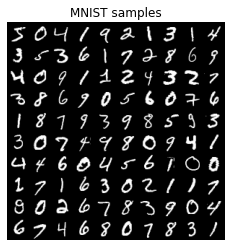

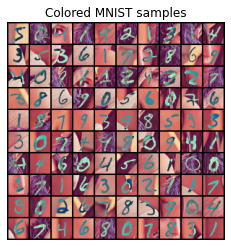

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

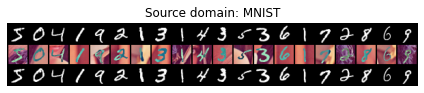

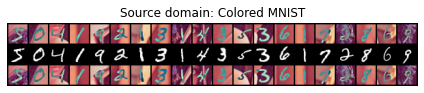

In [ ]:
b5_save_results(b5)